
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-2-Questions/blob/main/HW2_P1_SARSA_and_QLearning.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-2-Questions/blob/main/HW2_P1_SARSA_and_QLearning.ipynb)

# **HW2: SARSA(n) and Q-Learning(n)**
---


> - Full Name: **Payam Taebi**
> - Student ID: **400104867**

## **Overview**  

In this notebook, we will experiment with different reinforcement learning algorithms under various configurations to gain deeper insights into their behavior.  

By completing this homework, you will:  
- Understand **exploration vs. exploitation** and how they impact the learning process in an environment.  
- Learn how to **balance exploration and exploitation** effectively for optimal performance.  
- Recognize the importance of **epsilon decay** and when to use.  

Also, you will:  
- Gain a solid understanding of **n-step SARSA** and **n-step Q-learning**.  
- Explore how different values of **n** affect learning quality and efficiency.  
- Compare the strengths and trade-offs of **n-step SARSA vs. n-step Q-learning** to determine when to use each method.

---

We will start by learning how to implement **epsilon-greedy**, **n-step SARSA**, and **n-step Q-learning**.  

Next, we will implement a class that takes learning **hyperparameters** and includes a `learn` method, which accepts an algorithm (such as SARSA) and trains the environment accordingly.  

After that, we will experiment with **different epsilon values** to analyze their effect on the learning process. Finally, we will explore **different values of n** to gain deeper insights into **n-step SARSA** and **n-step Q-learning** and their impact on learning quality.


## **Environment Setup**
Setting up required libraries and environment.

In [ ]:
!sudo apt-get update --quiet
!pip install 'imageio==2.4.0' --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip3 install gymnasium[classic_control] --quiet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 264 kB in 2s (156 kB/s)
Reading package lists...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package

In [ ]:
import gymnasium as gym
import random
import base64
import imageio
import IPython
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.signal import convolve as conv
from collections import defaultdict

In [ ]:
# @title helper and plotting functions

# disable warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()


def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, policy, filename, Q=None, num_episodes=1, fps=5, max_steps=48):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, _ = env.reset()
            video.append_data(env.render())
            while max_steps >= 0:
                action = policy(state, Q)
                state, _, terminated, truncated, _ = env.step(action)
                max_steps -= 1
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def plot_heatmap(env, value, ax=None, show=False):
    # Generate heatmap showing maximum value at each state
    if ax is None:
        _, ax = plt.subplots()
    dim_x, dim_y = 12, 4
    action_max = value.argmax(axis=1)
    value_max = value.max(axis=1).reshape(dim_y, dim_x)
    act_dict = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    act_dict = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    labels = np.array([act_dict.get(action, '') for action in action_max])
    labels[37:-1], labels[-1] = ' ', 'G'
    labels = labels.reshape(dim_y, dim_x)
    im = sns.heatmap(value_max, cmap="inferno", annot=labels, annot_kws={'fontsize': 16}, fmt='s')
    if show:
        plt.show()
    return im


def plot_rewards(rewards, average_range=10, log=False, ax=None, show=False):
    # Generate plot showing total reward accumulated in each episode.
    n_episodes = len(rewards)
    if log:
        rewards = np.log10(-rewards)
    if ax is None:
        fig, ax = plt.subplots()
    smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)
    ax.plot(range(0, n_episodes, average_range), smoothed_rewards[0:n_episodes:average_range])
    ylab = 'Log of negative sum of rewards' if log else 'Total reward'
    ax.set(xlabel='Episodes', ylabel=ylab)
    if show:
      plt.show()


def plot_performance(env, value, reward_sums, log=False):
    fig, axes = plt.subplots(nrows=2, figsize=(12, 8))
    plot_rewards(reward_sums, ax=axes[0], log=log)
    plot_heatmap(env, value, ax=axes[1])
    plt.show(fig)

def plot_regret(regret_sums, average_range=10, ax=None, show=False):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(np.cumsum(regret_sums), color='orange', label="Cumulative Regret")
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Cumulative Regret")
    ax.set_title("Regret Over Time")
    ax.legend()
    ax.grid()

    if show:
        plt.show()

    return ax



In [ ]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
env.reset()


print('Observations:',env.observation_space )
print('Actions:',env.action_space )

Observations: Discrete(48)
Actions: Discrete(4)


## **Policy Definitions**
Implementing different policies for action selection.[link text](https://)

In [ ]:
Actions =[0,1,2,3]


def random_policy(state = None,Q = None):
    action = env.action_space.sample()

    return  action

In [ ]:
create_policy_eval_video(env = env, policy = random_policy,filename='random', max_steps=50)

In [ ]:
import numpy as np

def greedy_policy(state, Q):
    """Greedy policy: selects the maximum value action.

    Args:
      state (integer): current state
      Q (ndarray): current value function of shape (n_states, n_actions)

    Returns:
      action (integer): the chosen action
    """
    return np.argmax(Q[state])  # Select action with the highest Q-value


In [ ]:
def epsilon_greedy(state, Q, epsilon=0.1):
    """Epsilon-greedy policy: selects the maximum value action with probability
    (1-epsilon) and selects randomly with epsilon probability.

    Args:
      state (integer): current state
      Q (ndarray): current value function of shape (n_states, n_actions)
      epsilon (float): probability of selecting an action randomly

    Returns:
      action (integer): the chosen action
    """
    # With probability epsilon, choose a random action
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    # Otherwise, choose the greedy action
    else:
        return np.argmax(Q[state])


## **Evaluation & Visualization**
Analyzing policy performance.

In [ ]:
def evaluate_policy(env, Q, num_episodes=1, max_steps=100):
    # Initialize a list to store the total reward from each episode.
    rewards_list = []

    for episode in range(num_episodes):
        total_reward = 0
        # Initialize the environment;
        state, _ = env.reset()

        for step in range(max_steps):

            action = greedy_policy(state, Q)

            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            if terminated or truncated:
                break

        rewards_list.append(total_reward)

    # Return the mean and standard deviation of the rewards.
    return np.mean(rewards_list), np.std(rewards_list)


# Explanation of the Problem and Its Fix in n-step Methods

## Mathematical Background

In n-step methods (e.g., n-step SARSA), the Q-value update rule is given by:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( G_t^{(n)} - Q(s_t, a_t) \right)
$$

where the n-step return $ G_t^{(n)} $ is defined as:

$$
G_t^{(n)} = \sum_{k=0}^{n-1} \gamma^k \, r_{t+k} + \gamma^n Q(s_{t+n}, a_{t+n})
$$

- $ s_t $ and $ a_t $ are the state and action at the **beginning** of the n-step window.
- $ r_{t+k} $ are the rewards obtained at each subsequent time step.
- $ \gamma $ is the discount factor.
- $ \alpha $ is the learning rate.

## The Original Issue

In the original implementation, when the update condition (i.e., $ T \geq 0 $) is met, the code was directly passing the **current** `state` and `action` to the learning rule. This was problematic because:

- **Mathematically:** The update should be applied to the state–action pair at the **start** of the n-step window, not the current one.
- **In Code:** Without storing the previous states and actions, the algorithm updates the wrong Q-value. This misalignment violates the intended formulation:

  $$
  Q(s_T, a_T) \leftarrow Q(s_T, a_T) + \alpha \left( G_T^{(n)} - Q(s_T, a_T) \right)
  $$

  where $ T = t - n $ (or $ t - n + 1 $, depending on indexing).

## How the Bug Was Fixed

The fix involves **storing** the states and actions encountered during the episode so that when the update is performed, the correct $ s_T $ and $ a_T $ are used. The solution is as follows:

- **Storing States and Actions:**  
  Create two lists:
  - `states` to record each state at time step $ t $.
  - `actions` to record each action taken at time step $ t $.

- **Using the Correct Indices for Updates:**  
  When the condition $ T \geq 0 $ is met (with $ T = t - n $ or $ T = t - n + 1 $), retrieve:
  - $ s_T = \text{states}[T] $
  - $ a_T = \text{actions}[T] $
  
  Then, apply the n-step update using these stored values.

This change ensures that the update:

$$
Q(s_T, a_T) \leftarrow Q(s_T, a_T) + \alpha \left( G_T^{(n)} - Q(s_T, a_T) \right)
$$

uses the correct state–action pair from the beginning of the n-step window, thereby aligning the implementation with the mathematical definition.

## Summary

- **Problem:** The update was being performed using the current state and action instead of the state and action from the start of the n-step window.
- **Fix:** Store each state and action in lists and use the stored values at index $ T = t - n $ (or $ t - n + 1 $) when updating the Q-values.
- **Result:** The corrected implementation now properly applies the n-step update according to the theoretical formulation.


In [ ]:
from collections import deque

class learnEnvironment:
    def __init__(self, env, episodes, n, alpha, max_step, epsilon=0.1, discount=0.95):
        self.n = n
        self.episodes = episodes
        self.Q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.Return_list = []
        self.alpha = alpha
        self.discount = discount
        self.max_step = max_step
        self.epsilon = epsilon

    def learn(self, env, learning_rule, epsilon_greedy_policy):
        for episode in range(self.episodes):
            t = 0
            total_return = 0
            n_step_reward = deque(maxlen=self.n)
            states = []   # Store states from each time step
            actions = []  # Store actions from each time step

            # Initialize environment and store the starting state
            state, _ = env.reset()
            states.append(state)

            while True:
                # Select an action using epsilon-greedy policy
                action = epsilon_greedy_policy(state, self.Q_table, self.epsilon)
                actions.append(action)

                next_state, reward, terminated, truncated, info = env.step(action)
                total_return += reward

                # Store reward and next state
                n_step_reward.append(reward)
                states.append(next_state)

                t += 1

                # Determine the time index T corresponding to the start of this n-step segment.
                # (Here we use T = t - n; you might also see T = t - n + 1 depending on indexing.)
                T = t - self.n
                if T >= 0:
                    # Use the stored state and action at time T for the update
                    update_state = states[T]
                    update_action = actions[T]
                    # For bootstrapping, if the deque is full, use the state at index T+n
                    if len(n_step_reward) == self.n:
                        bootstrap_state = states[T + self.n]
                    else:
                        bootstrap_state = next_state
                    self.Q_table = learning_rule(n_step_reward, self.Q_table, update_state, update_action, bootstrap_state, self.discount, self.n, self.alpha)

                # Check for episode termination or max steps reached
                if terminated or truncated or t > self.max_step:
                    # Optionally, perform any final updates for remaining time indices
                    # For simplicity, we just append the total return and break.
                    self.Return_list.append(total_return)
                    break

                state = next_state

        return self.Q_table, self.Return_list


In [ ]:
#@title N-step Sarsa_algortihm
def calculate_n_step_Return(n_step_reward,discount = 0.95):
  G = 0
  for r in reversed(n_step_reward):
    G = discount*G + r

  return G

def sarsa(n_step_reward, Q, state, action, next_state, discount, n, alpha, epsilon=0.1):
    """N-step SARSA update: updates the value function and returns it.

    Args:
      n_step_reward (deque): deque containing the last n rewards.
      Q (ndarray): current value function of shape (n_states, n_actions)
      state (int): the state for which the update is computed (at time t)
      action (int): the action taken in that state
      next_state (int): the state reached at time t+n (or the most recent next state)
      discount (float): discount factor (gamma)
      n (int): number of steps to look ahead
      alpha (float): learning rate
      epsilon (float): parameter for epsilon-greedy (used in bootstrapping)

    Returns:
      Q (ndarray): the updated value function of shape (n_states, n_actions)
    """
    # Calculate the discounted sum of rewards over the n steps.
    G = calculate_n_step_Return(n_step_reward, discount)

    # If the n-step deque is full, it means we have n rewards and a valid next_state to bootstrap from.
    # In this case, we select the next action using epsilon-greedy and add the bootstrapping term.
    if len(n_step_reward) == n:
        next_action = epsilon_greedy(next_state, Q, epsilon)
        G += (discount ** n) * Q[next_state, next_action]

    # Compute the TD error: difference between the n-step return and the current Q-value.
    td_error = G - Q[state, action]

    # Update the Q-value for the state-action pair.
    Q[state, action] += alpha * td_error

    return Q


In [ ]:
#@title N-step Q-learning_algortihm

def n_step_q_learning(n_step_reward, Q, state, action, next_state, discount, n, alpha):
    """
    N-step Q-learning: updates the value function (Q) and returns it.

    Args:
      n_step_reward (list or deque): the rewards collected over n steps
      Q (ndarray): current value function of shape (n_states, n_actions)
      state (int): the original state from which the first action was taken
      action (int): the action taken at the original state
      next_state (int): the resulting state after n steps
      discount (float): discount factor (gamma)
      n (int): number of steps
      alpha (float): learning rate

    Returns:
      Q (ndarray): the updated value function of shape (n_states, n_actions)
    """
    # Calculate the discounted sum of rewards over the n steps.
    G = calculate_n_step_Return(n_step_reward, discount)

    # If we have collected n rewards, bootstrap from the next state using the max Q-value.
    if len(n_step_reward) == n:
        G += (discount ** n) * np.max(Q[next_state])

    # Compute the temporal difference error.
    td_error = G - Q[state, action]

    # Update the Q-value for the state-action pair.
    Q[state, action] += alpha * td_error

    return Q


# **Exploration vs. Exploitation Trade-off**
In reinforcement learning, an agent must balance between:
- **Exploration**: Trying new actions to discover potentially better long-term rewards.
- **Exploitation**: Choosing the best-known action based on current knowledge to maximize immediate reward.

### **Why is this Trade-off Important?**
- Too much **exploration** → The agent wastes time taking suboptimal actions and miss the optimal reward.
- Too much **exploitation** → The agent might **get stuck in a suboptimal policy** without discovering new possibilities for a better strategy.

### **Epsilon-Greedy Policy**:  
   - With probability $\epsilon$, the agent **explores** (chooses a random action).  
   - With probability $\epsilon$, the agent **exploits** (chooses the best-known action).  
   - $\epsilon$ is often **decayed over time** to gradually shift from exploration to exploitation.

---

# **Regret in Reinforcement Learning**
Regret in reinforcement learning measures the **difference between the reward an agent actually receives** and the **maximum possible reward it could have received** under an optimal policy. It quantifies **learning inefficiency** and helps evaluate how well an agent balances exploration and exploitation.

### **Mathematical Definition**
Given:
- $R_t^{\text{optimal}}$ is the reward the agent **could have obtained** in timestep $ t $ under the optimal policy.
- $R_t$ is the **actual reward** obtained by the agent in timestep $ t $.

The **instantaneous regret** at time $ t $ is:

$$
\text{Regret}(t) = R_t^{\text{optimal}} - R_t
$$

The **cumulative regret** over $ T $ timesteps is:

$$
\text{Cumulative Regret}(T) = \sum_{t=1}^{T}  ( R_t^{\text{optimal}} - R_t)
$$
A well-trained RL agent should aim to **minimize regret** over time.

---






SARSA mean_reward = -17.00 +/- 0.0000



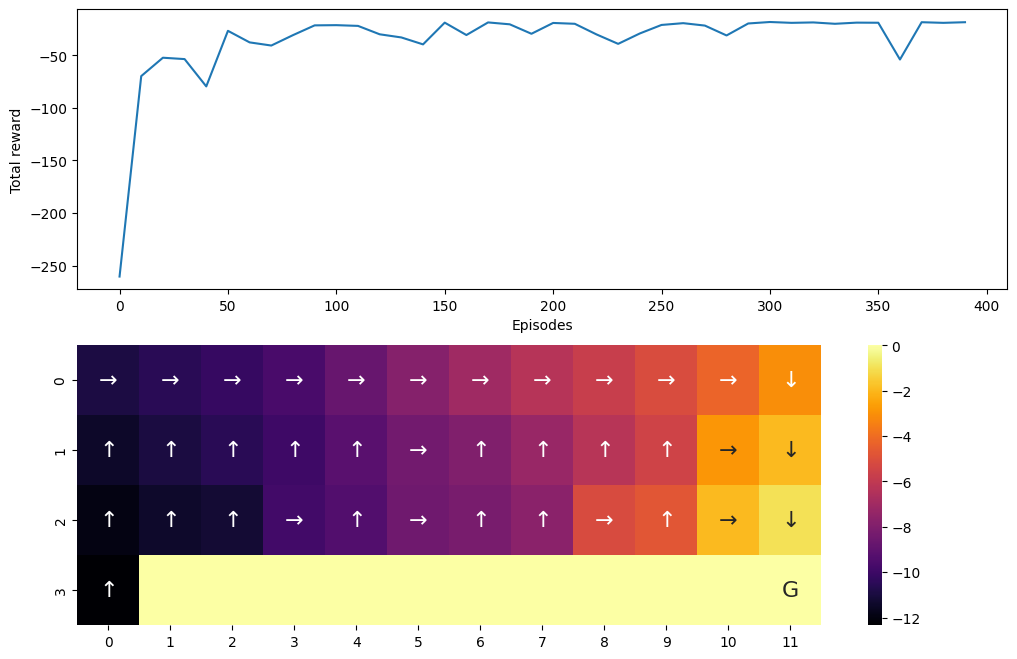

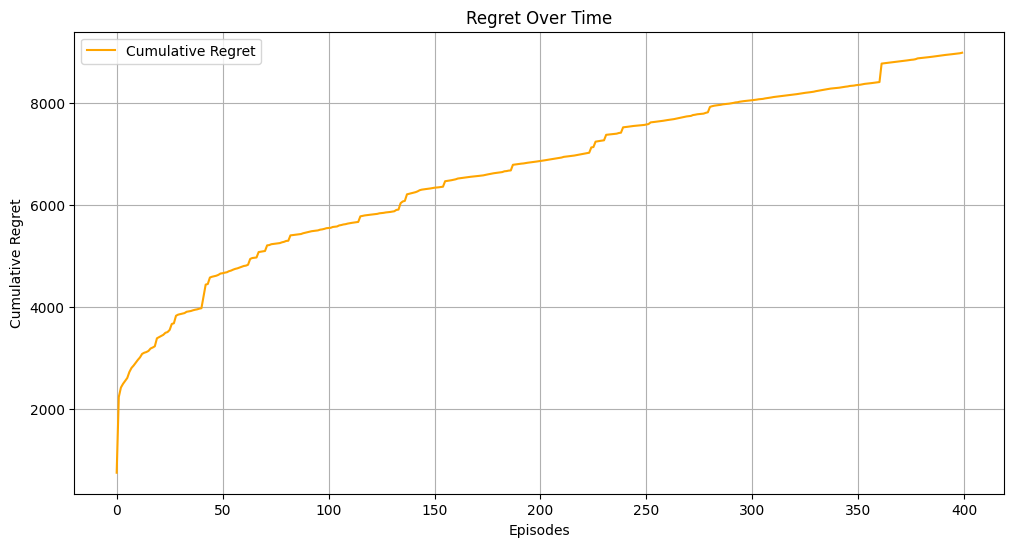

In [ ]:
# @title epsilon = 0.1
optimal_reward = -13  # Best case scenario

# TODO: Set number of episodes/trials
n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000
# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env,n_episodes,n,alpha,max_step,epsilon=0.1)



# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Initialize lists to track regret
regret_sums_sarsa = []

# Compute regret for each episode
regret_sums_sarsa = [optimal_reward - r for r in reward_sums_sarsa]

# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

plot_performance(env, value_sarsa, reward_sums_sarsa)

# Plot regret
plot_regret(regret_sums_sarsa, show=True)

# Turn on render mode and visualize policy evaluation (optional)
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



SARSA mean_reward = -17.00 +/- 0.0000



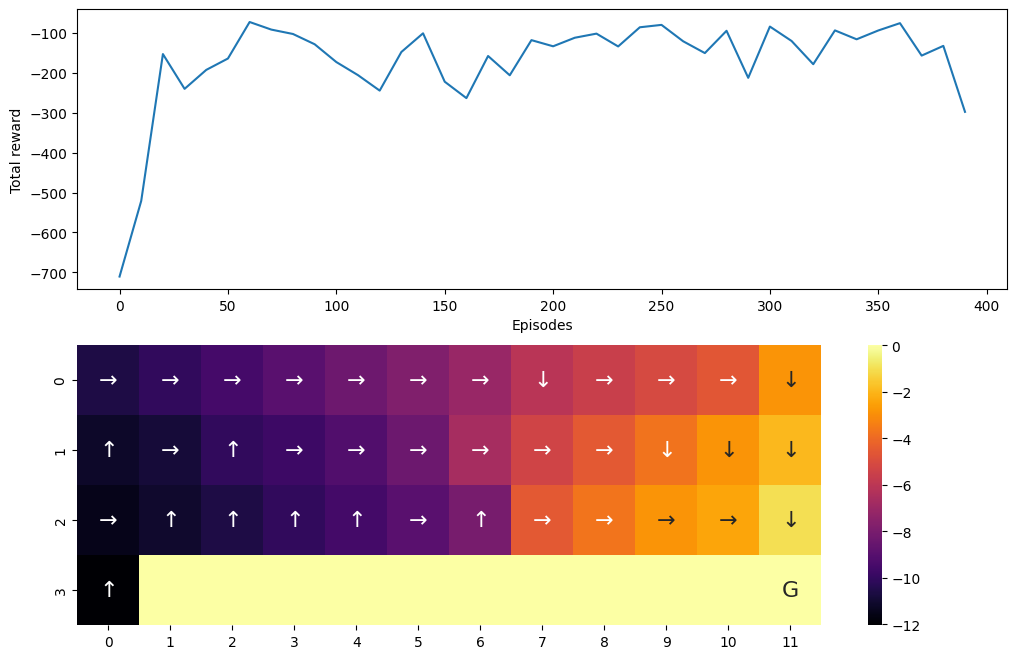

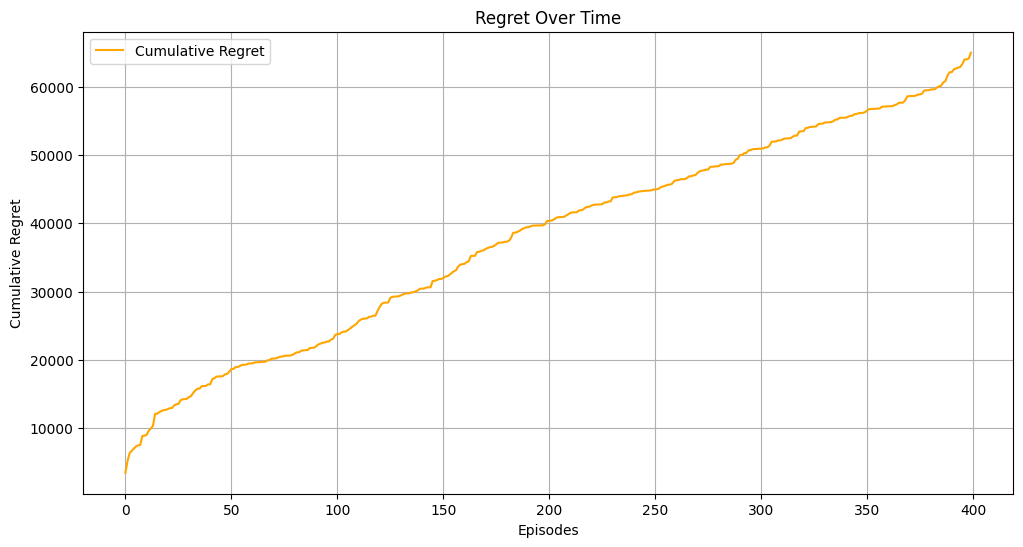

In [ ]:
# @title epsilon = 0.5
optimal_reward = -13  # Best case scenario

# Set number of episodes/trials and hyperparameters
n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.5)

# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Initialize lists to track regret
regret_sums_sarsa = [optimal_reward - r for r in reward_sums_sarsa]

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot performance: rewards over episodes and Q-value heatmap
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Plot cumulative regret
plot_regret(regret_sums_sarsa, show=True)

# Turn on render mode and visualize policy evaluation (optional)
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



SARSA mean_reward = -15.00 +/- 0.0000



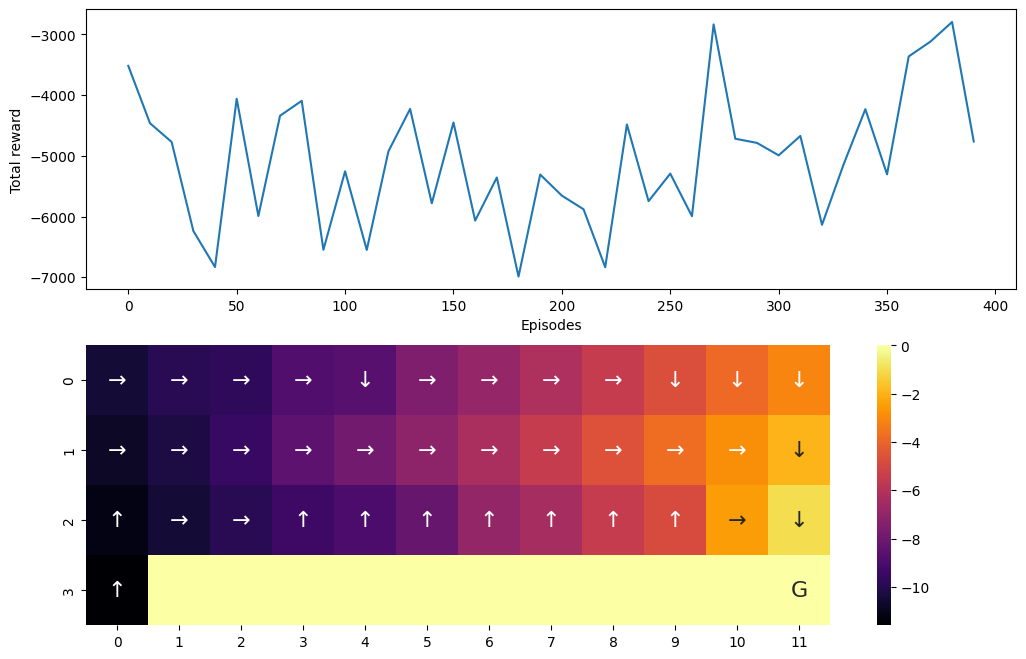

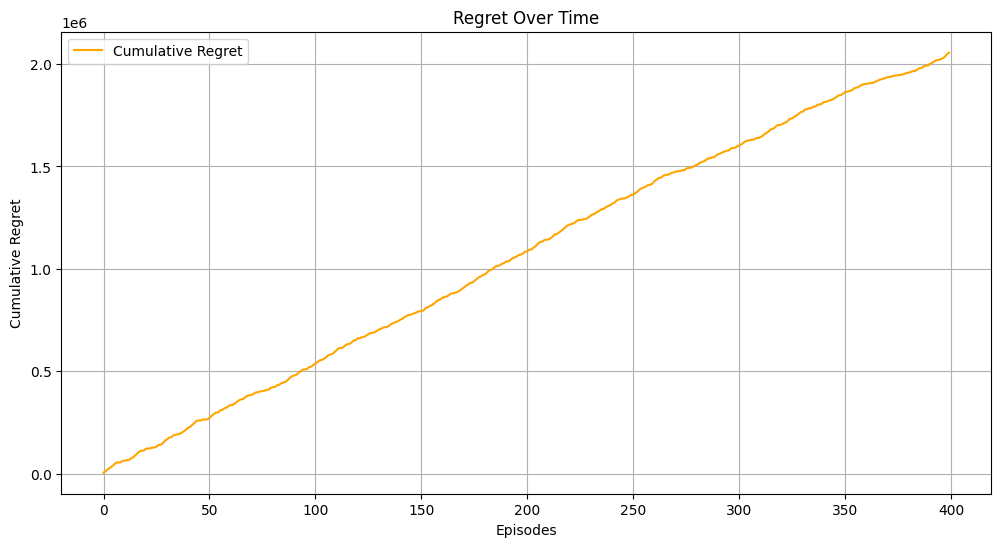

In [ ]:
# @title epsilon = 0.9
optimal_reward = -13  # Best case scenario

# Set number of episodes/trials and hyperparameters
n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.9)

# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Initialize lists to track regret
regret_sums_sarsa = [optimal_reward - r for r in reward_sums_sarsa]

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot performance: rewards over episodes and Q-value heatmap
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Plot cumulative regret
plot_regret(regret_sums_sarsa, show=True)


# Turn on render mode and visualize policy evaluation (optional)
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)


Fast Decay


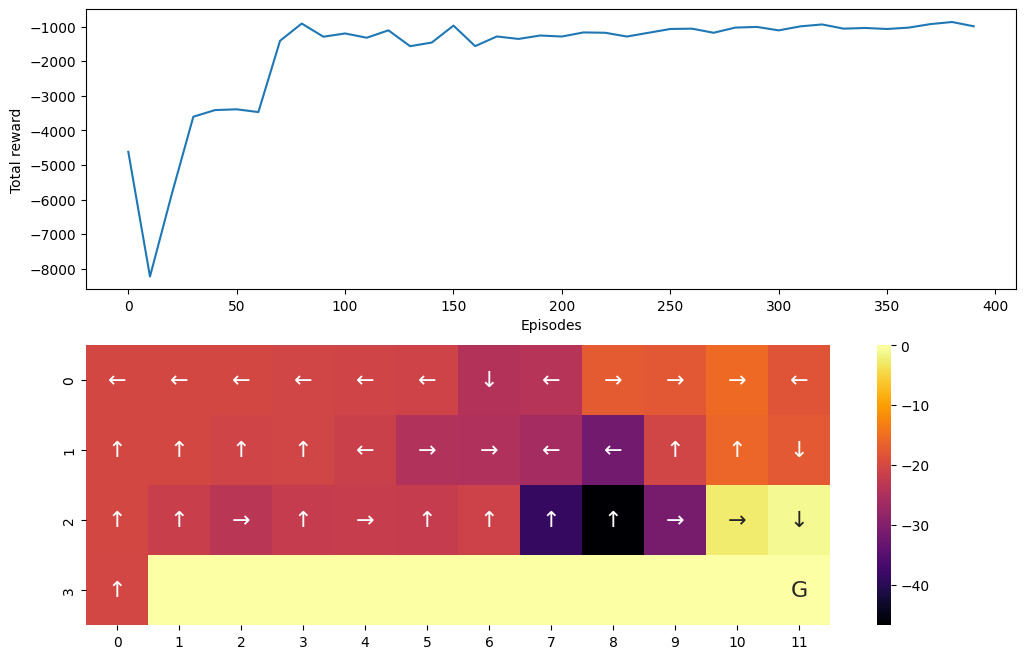


Fast Decay SARSA mean_reward = -100.00 +/- 0.0000
Medium Decay


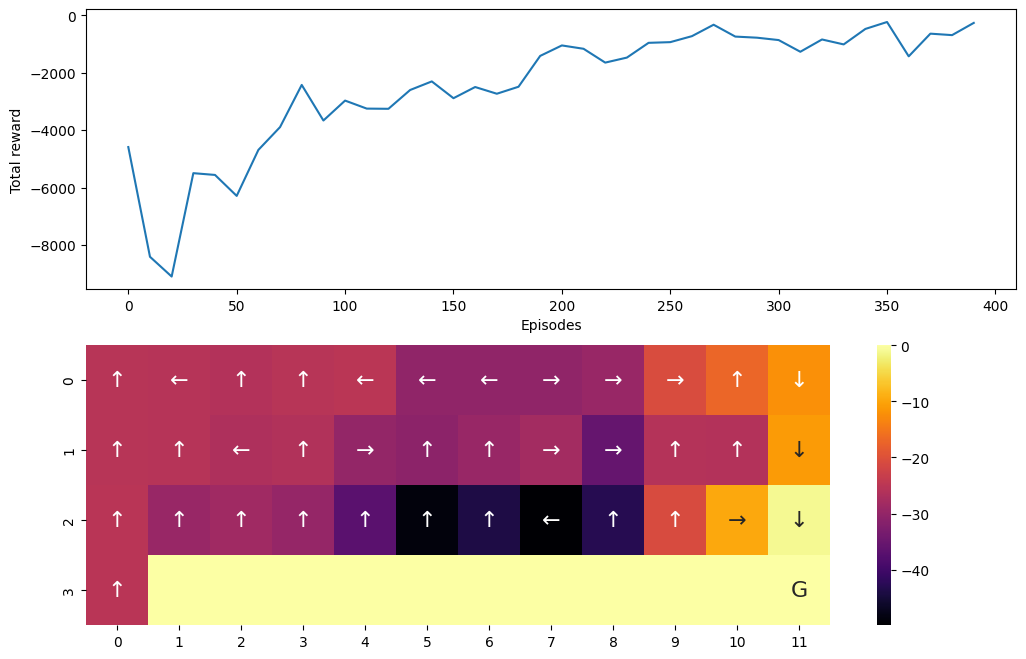


Medium Decay SARSA mean_reward = -100.00 +/- 0.0000
Slow Decay


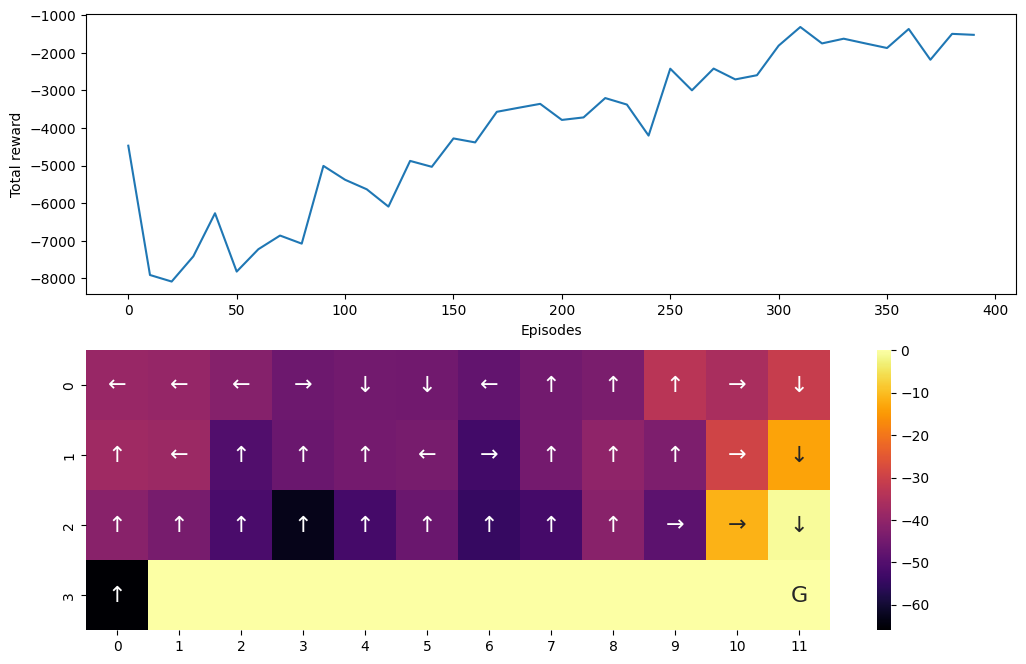


Slow Decay SARSA mean_reward = -100.00 +/- 0.0000


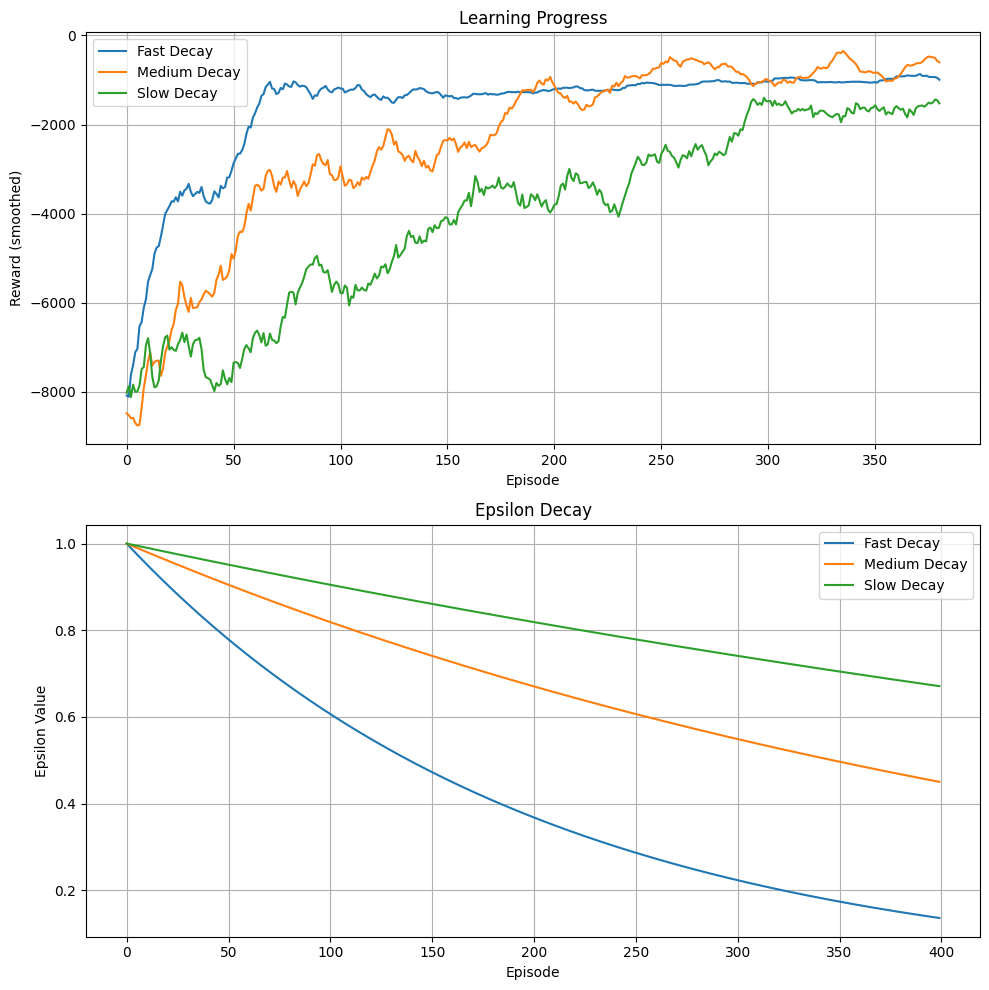

In [ ]:
# @title Epsilon Decay
class EpsilonDecayStrategy:
    def __init__(self, initial_epsilon, min_epsilon, decay_rate):
        self.initial_epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.epsilon = initial_epsilon

    def get_epsilon(self, episode):
        """Calculate epsilon using exponential decay."""
        self.epsilon = max(
            self.min_epsilon,
            self.initial_epsilon * np.exp(-self.decay_rate * episode)
        )
        return self.epsilon

class learnEnvironmentWithEpsilonStrategy:
    def __init__(self, policy, env, n_episodes, n, alpha, max_step, epsilon_strategy):
        self.policy = policy
        self.env = env
        self.n_episodes = n_episodes
        self.n = n
        self.alpha = alpha
        self.max_step = max_step
        self.epsilon_strategy = epsilon_strategy

    def learn(self, env, algorithm):
        n_states = env.observation_space.n
        n_actions = env.action_space.n
        Q = np.zeros((n_states, n_actions))
        reward_sums = np.zeros(self.n_episodes)
        epsilon_values = np.zeros(self.n_episodes)

        for episode in range(self.n_episodes):
            state, _ = env.reset()
            episode_reward = 0
            n_step_reward = []

            # Get current epsilon
            current_epsilon = self.epsilon_strategy.get_epsilon(episode)
            epsilon_values[episode] = current_epsilon

            for step in range(self.max_step):
                action = self.policy(state, Q, current_epsilon)
                next_state, reward, terminated, truncated, _ = env.step(action)
                episode_reward += reward
                n_step_reward.append(reward)

                if len(n_step_reward) >= self.n:
                    Q = algorithm(
                        n_step_reward[-self.n:],
                        Q, state, action, next_state,
                        0.95, self.n, self.alpha,
                        current_epsilon
                    )

                if terminated or truncated:
                    break

                state = next_state

            reward_sums[episode] = episode_reward

        return Q, reward_sums, epsilon_values

def plot_results(reward_sums_list, epsilon_values_list, labels):
    """Plot rewards and epsilon decay for multiple runs."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot rewards
    for rewards, label in zip(reward_sums_list, labels):
        # Smoothing the rewards
        window_size = 20
        smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        ax1.plot(smoothed_rewards, label=label)

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward (smoothed)')
    ax1.set_title('Learning Progress')
    ax1.legend()
    ax1.grid(True)

    # Plot epsilon decay
    for epsilons, label in zip(epsilon_values_list, labels):
        ax2.plot(epsilons, label=label)

    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Epsilon Value')
    ax2.set_title('Epsilon Decay')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

# Set for reproducibility
np.random.seed(42)

# Define different epsilon decay strategies
epsilon_strategies = [
    EpsilonDecayStrategy(1.0, 0.01, 0.005),  # Fast decay
    EpsilonDecayStrategy(1.0, 0.01, 0.002),  # Medium decay
    EpsilonDecayStrategy(1.0, 0.01, 0.001)   # Slow decay
]

# Parameters
n_episodes = 400
n = 1
discount = 0.95
alpha = 0.5
max_step = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')

# Store results for different strategies
all_rewards = []
all_epsilons = []
strategy_labels = ['Fast Decay', 'Medium Decay', 'Slow Decay']

# Run learning for each strategy
for strategy, label in zip(epsilon_strategies, strategy_labels):
    learning_algorithm = learnEnvironmentWithEpsilonStrategy(
        epsilon_greedy, env, n_episodes, n, alpha, max_step, strategy
    )
    value_sarsa, reward_sums, epsilon_values = learning_algorithm.learn(env, sarsa)
    all_rewards.append(reward_sums)
    all_epsilons.append(epsilon_values)

    print(label)
    plot_performance(env, value_sarsa, reward_sums)

    mean_reward, std_reward = evaluate_policy(env, value_sarsa)
    print(f"\n{label} SARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

# Plot results
plot_results(all_rewards, all_epsilons, strategy_labels)
plt.show()

### **Why does epsilon 0.1 have the best performance?**  
In this environment, the reward for stepping into the cliff is -100, which is highly punishing. Because of this, exploration is not highly favored, making a lower epsilon (0.1) more effective as it prioritizes safer, learned actions over risky exploration.

# N-step Sarsa and N-step Q-learning

In [ ]:
# Set number of episodes/trials and hyperparameters
n_episodes = 500       # Number of episodes
discount = 0.9        # Discount factor (gamma)
alpha = 0.1           # Learning rate
max_step = 1000        # Maximum steps per episode

## Effect of  n = 1

In [ ]:
n = 1


SARSA mean_reward = -15.00 +/- 0.0000



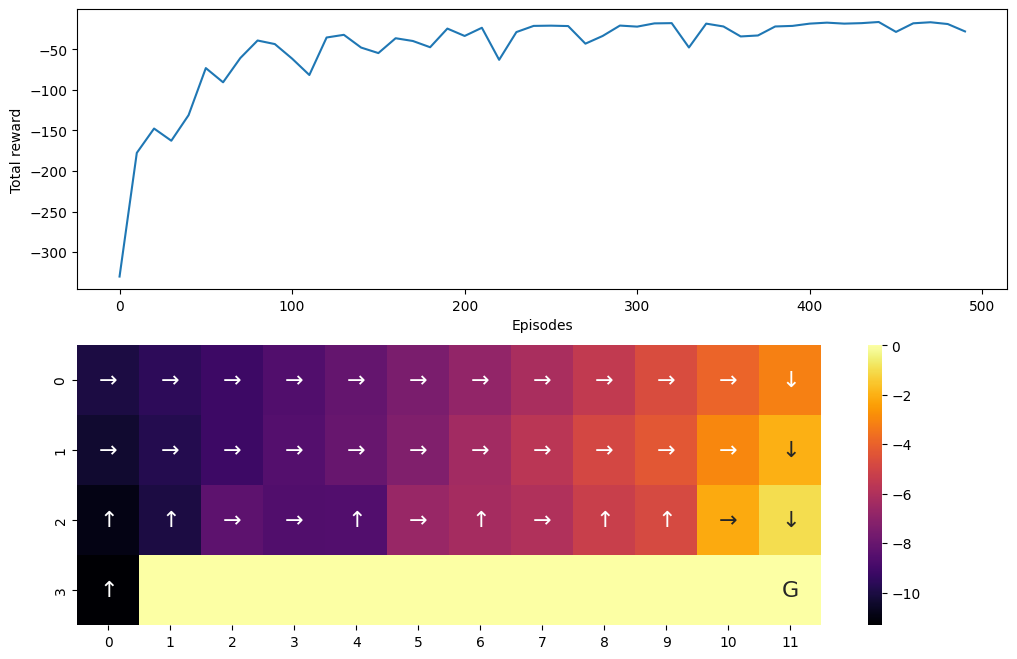

In [ ]:
#@title Sarsa
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)


# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Turn on render mode to create a policy evaluation video
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



qlearning mean_reward = -13.00 +/- 0.0000



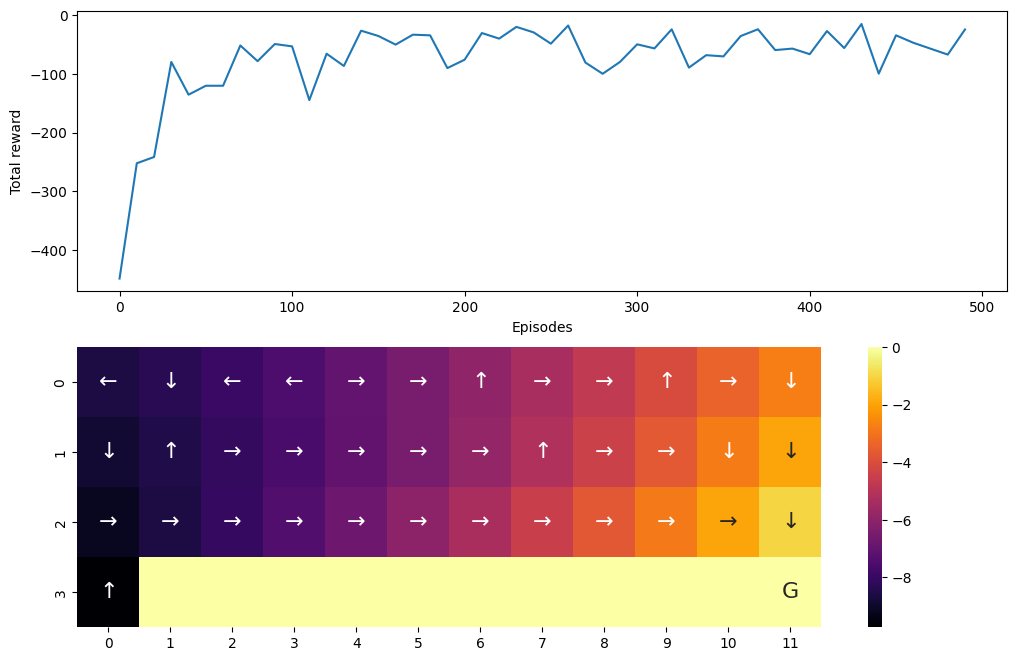

In [ ]:
#@title Q-learning
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)



# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using n-step Q-learning
results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_qlearning, reward_sums_qlearning)

# Optional: Turn on render mode to visualize the learned policy
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)


## Effect of  n = 2

In [ ]:
n = 2


SARSA mean_reward = -17.00 +/- 0.0000



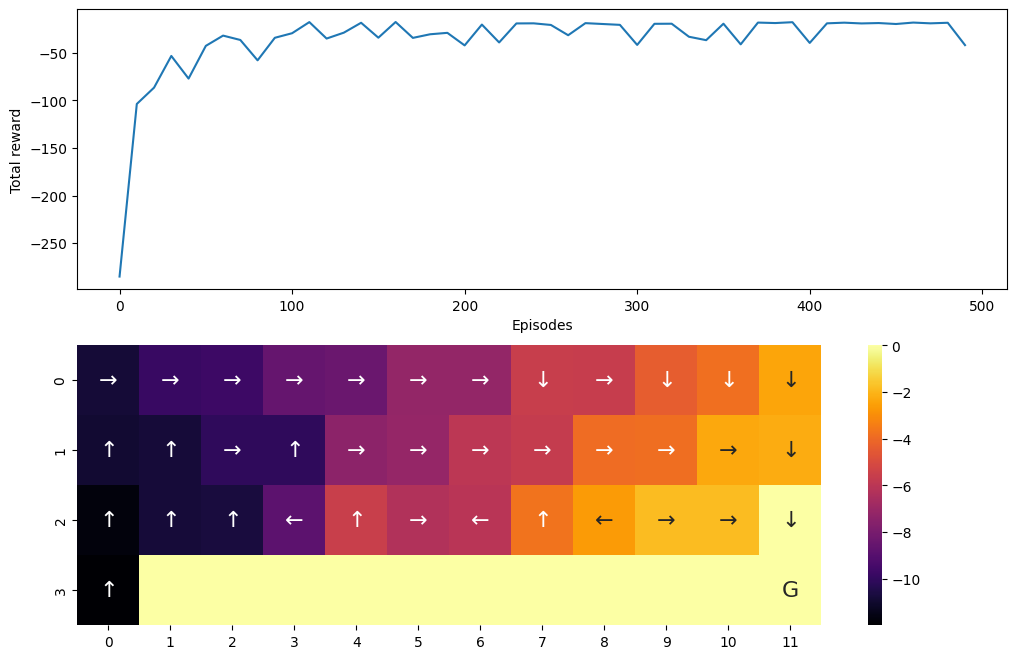

In [ ]:
#@title Sarsa
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)



# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using SARSA (with n=2)
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Optional: Turn on render mode to visualize the learned policy
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



qlearning mean_reward = -15.00 +/- 0.0000



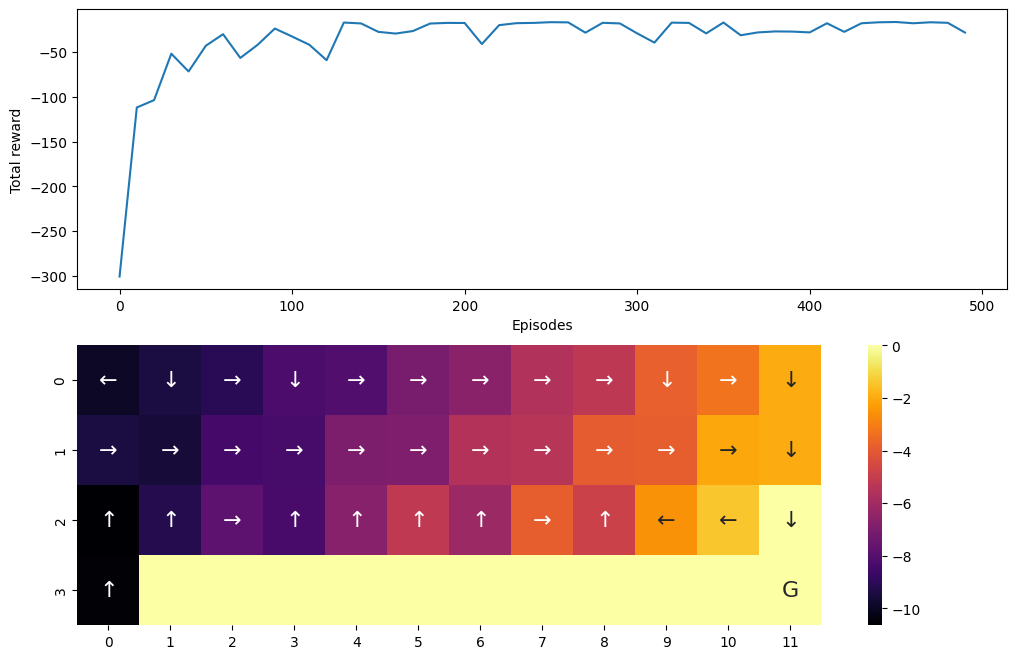

In [ ]:
#@title Q-learning
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)


# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using n-step Q-learning
results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_qlearning, reward_sums_qlearning)

# Optional: Turn on render mode to visualize the learned policy
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)


## Effect of  n = 5

In [ ]:
n = 5


SARSA mean_reward = -17.00 +/- 0.0000



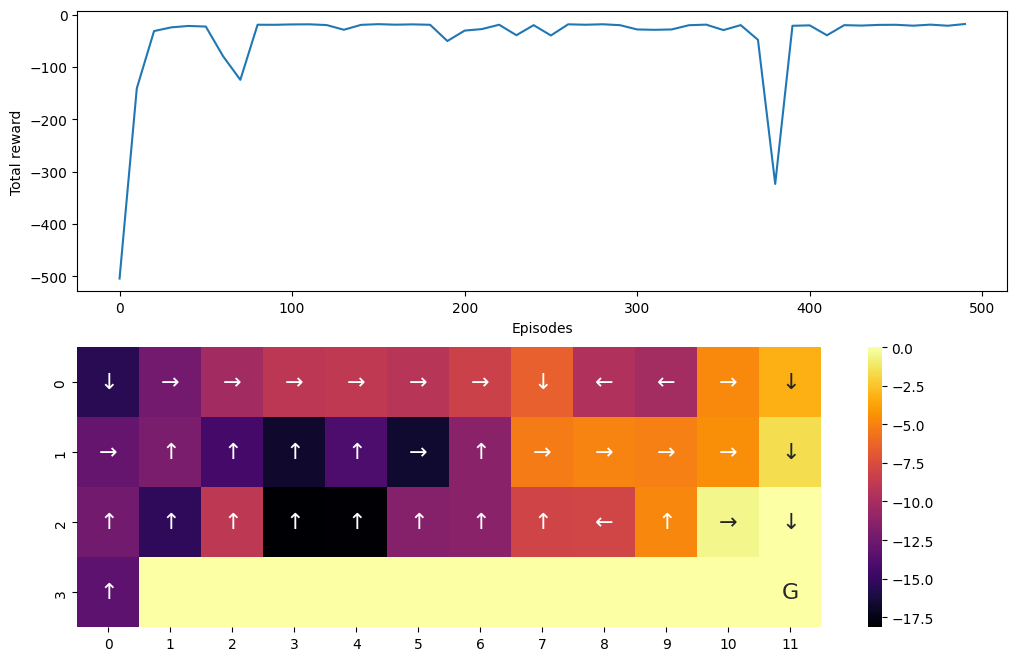

In [ ]:
#@title Sarsa
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)


# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using SARSA with n=5
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Optional: Turn on render mode to visualize the learned policy
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)



qlearning mean_reward = -17.00 +/- 0.0000



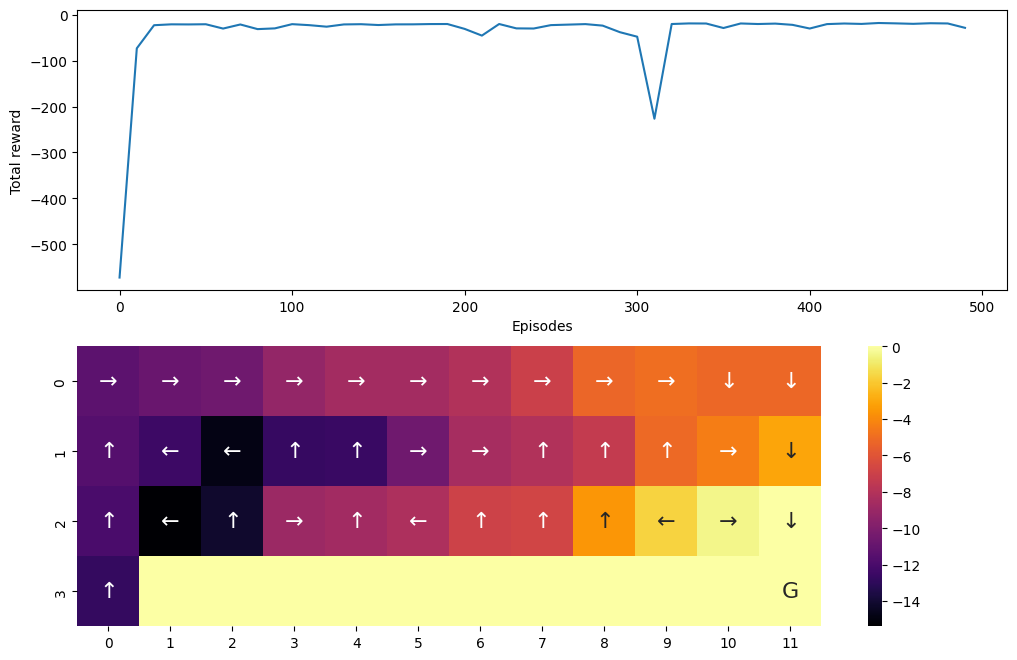

In [ ]:
#@title Q-learning
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)



# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using n-step Q-learning
results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_qlearning, reward_sums_qlearning)

# Optional: Turn on render mode to visualize the learned policy
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)


now i want to test with other parameter alpha = 0.01 to see if big n help us or not


SARSA mean_reward = -100.00 +/- 0.0000



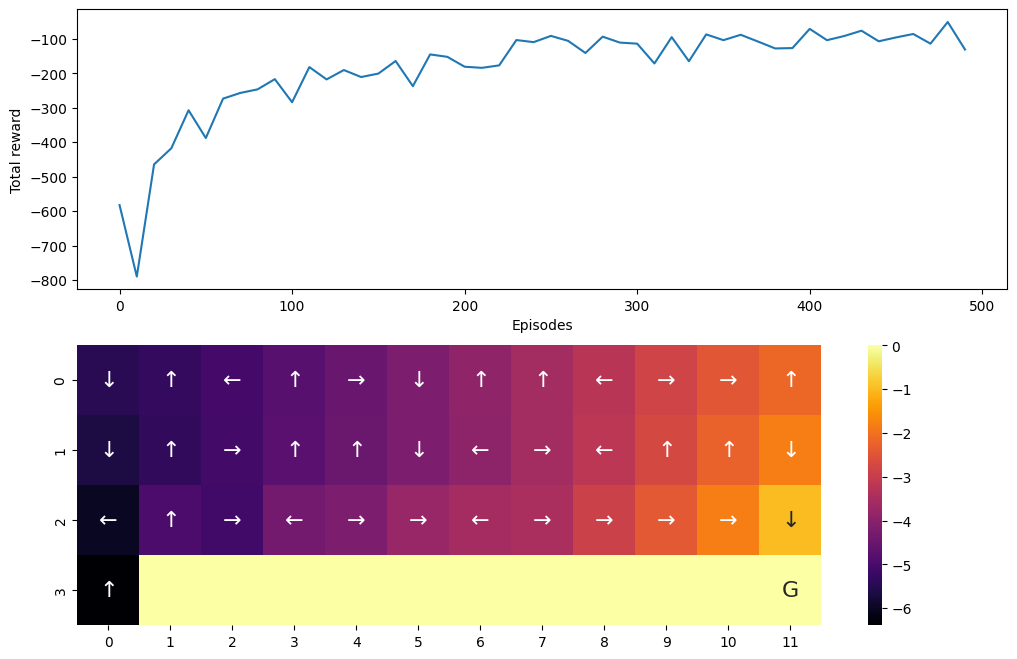


qlearning mean_reward = -100.00 +/- 0.0000



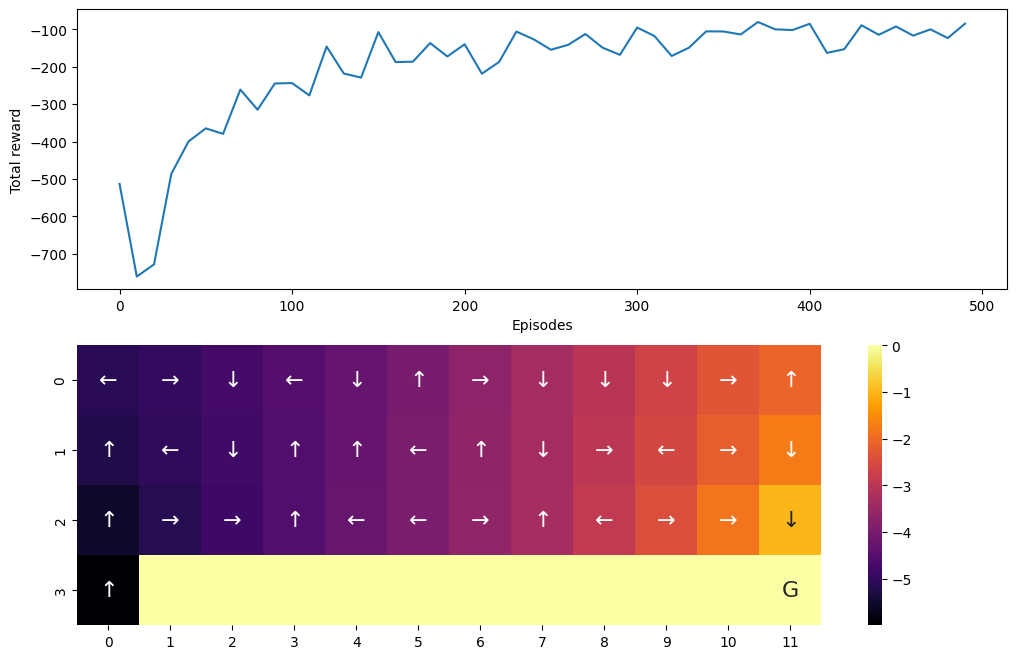


SARSA mean_reward = -100.00 +/- 0.0000



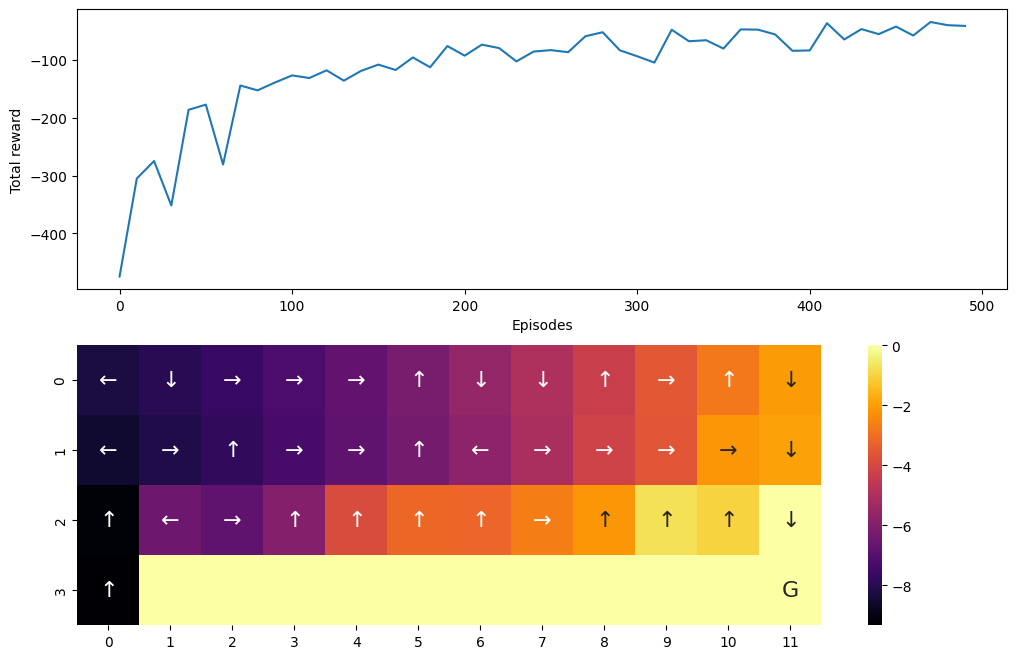


qlearning mean_reward = -100.00 +/- 0.0000



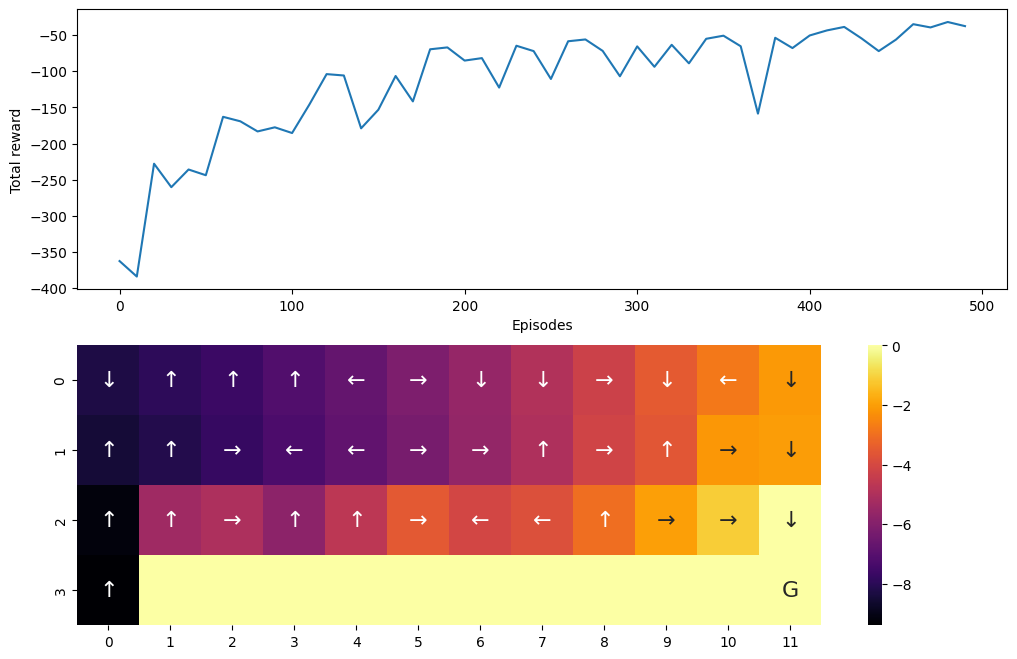


SARSA mean_reward = -17.00 +/- 0.0000



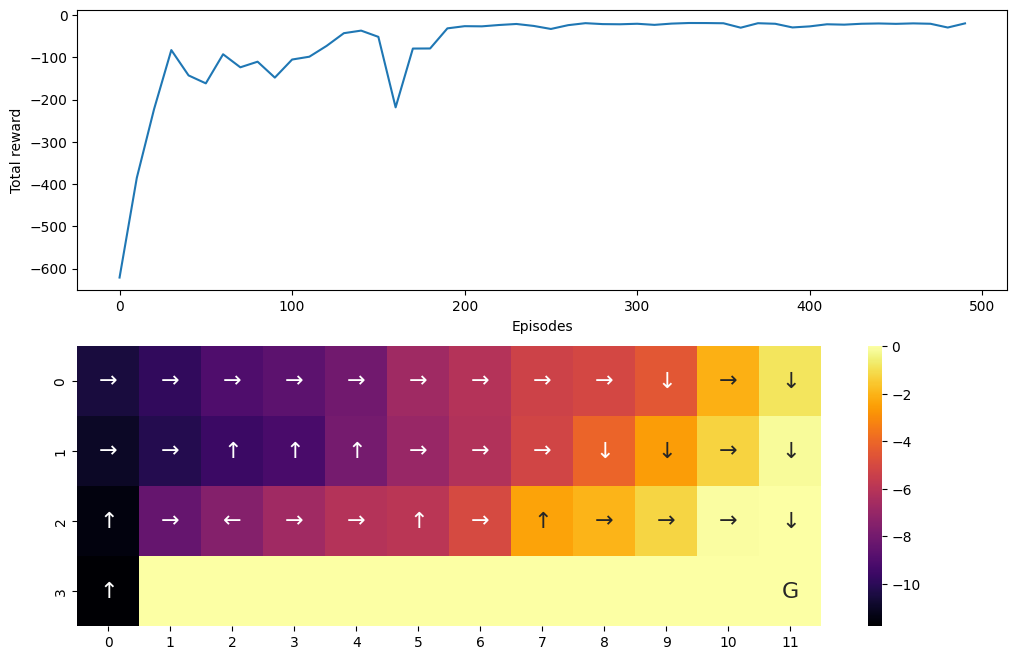


qlearning mean_reward = -17.00 +/- 0.0000



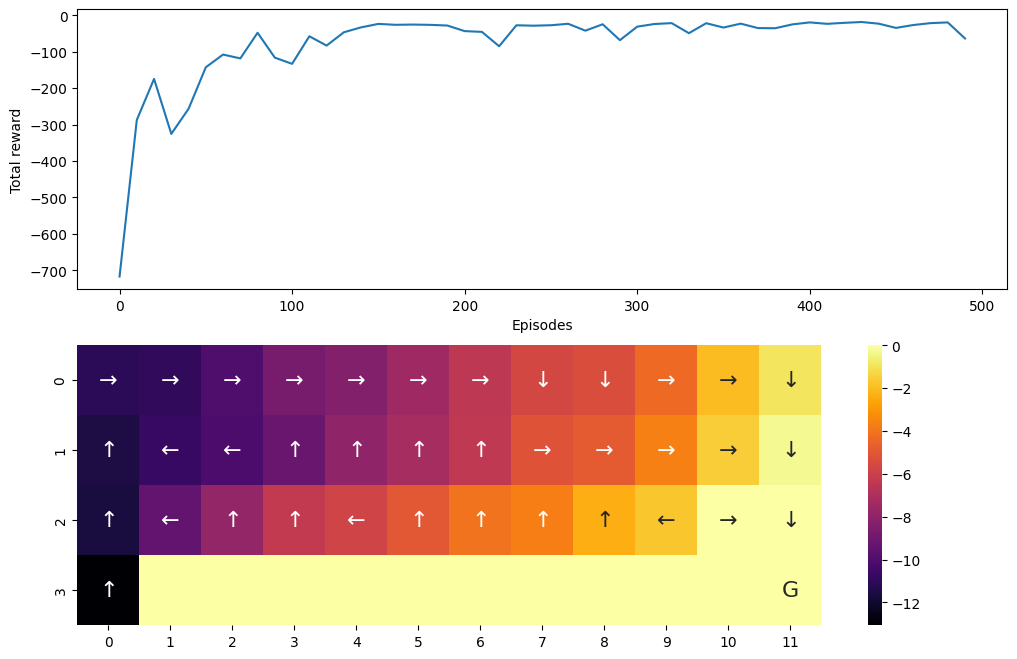

In [ ]:
# Set number of episodes/trials and hyperparameters
n_episodes = 500       # Number of episodes
discount = 0.9        # Discount factor (gamma)
alpha = 0.01           # Learning rate
max_step = 1000        # Maximum steps per episode
n = 1

# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)


# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using SARSA
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Turn on render mode to create a policy evaluation video
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)


#@title no title
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)



# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using n-step Q-learning
results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_qlearning, reward_sums_qlearning)

# Optional: Turn on render mode to visualize the learned policy
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)


n = 2



#@title Sarsa
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)



# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using SARSA (with n=2)
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Optional: Turn on render mode to visualize the learned policy
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)


#@title Q-learning
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)


# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using n-step Q-learning
results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_qlearning, reward_sums_qlearning)

# Optional: Turn on render mode to visualize the learned policy
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)


n = 5


#@title Sarsa
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)


# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using SARSA with n=5
results = learning_algorithm.learn(env, sarsa, epsilon_greedy)
value_sarsa, reward_sums_sarsa = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Optional: Turn on render mode to visualize the learned policy
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)


#@title Q-learning
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)



# Initialize environment
env = gym.make('CliffWalking-v0')

learning_algorithm = learnEnvironment(env, n_episodes, n, alpha, max_step, epsilon=0.1)

# Solve Cliff Walking using n-step Q-learning
results = learning_algorithm.learn(env, n_step_q_learning, epsilon_greedy)
value_qlearning, reward_sums_qlearning = results

# Evaluate the learned policy using a greedy policy
mean_reward, std_reward = evaluate_policy(env, value_qlearning)
print(f"\nqlearning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results: rewards over episodes and Q-value heatmap
plot_performance(env, value_qlearning, reward_sums_qlearning)

# Optional: Turn on render mode to visualize the learned policy
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'qlearning', value_qlearning)
